# Learning Hermitian Metric with Neural Network

This notebook trains a feedforward neural network to learn the Hermitian metric from CY point coordinates.

**Goal:** Learn the real and imaginary parts of the upper triangular components of the 3×3 Hermitian metric.

**Output:** 12D vector (6 complex components → 12 real values)
- Upper triangle indices: (0,0), (0,1), (0,2), (1,1), (1,2), (2,2)
- Each split into real and imaginary parts

**Steps:**
1. Setup and generate CY points
2. Compute Hermitian metric using CyMetric model
3. Prepare training data (extract upper triangle components)
4. Train neural network
5. Test on independent sample

## 1. Import Libraries

In [ ]:
# Import standard libraries
import os
import sys
import yaml
import numpy as np
import tensorflow as tf
import pickle
import pathlib
import matplotlib.pyplot as plt

# Setup path for cymetric package (from scratch/ to github/)
_parent_dir = pathlib.Path(os.getcwd()).parent
_cymetric_dir = _parent_dir.parent / "cymetric"
if str(_parent_dir) not in sys.path:
    sys.path.insert(0, str(_parent_dir))
if str(_cymetric_dir) not in sys.path:
    sys.path.insert(0, str(_cymetric_dir))

# Create alias to fix cymetric internal imports
import cymetric
if hasattr(cymetric, 'cymetric'):
    sys.modules['cymetric'] = cymetric.cymetric

# Import geometry functions
from geometry.patches import CoordChange_C5R10

# Import cymetric functions
from cymetric.pointgen.pointgen import PointGenerator
from cymetric.models.tfhelper import prepare_tf_basis
from cymetric.models.tfmodels import PhiFSModel

print("✅ All imports successful!")

✅ All imports successful!


## 2. Load Configuration

In [ ]:
# Set up paths (go to parent directory)
cymodel_name = ''  # Set to '_name' if using named model
parent_dir = os.path.dirname(os.getcwd())
dirname = os.path.join(parent_dir, 'models', 'cy_models', 'link_data')
config_path = os.path.join(parent_dir, f'models/cy_models/cy_model_config{cymodel_name}.yaml')
cymodel_path = os.path.join(parent_dir, f'models/cy_models/cy_metric_model{cymodel_name}.keras')

# Load configuration
with open(config_path, 'r') as f:
    config = yaml.unsafe_load(f)

print("Configuration loaded:")
print(f"  Monomials shape: {np.array(config['monomials']).shape}")
print(f"  Ambient dimension: {config['ambient']}")

Configuration loaded:
  Monomials shape: (5, 5)
  Ambient dimension: [4]


## 3. Generate Training Data

In [3]:
# Generate training points
n_train = 300000  # Number of training points

print(f"Generating {n_train} training CY points...")

# Initialize point generator
pg = PointGenerator(
    config['monomials'], 
    config['coefficients'], 
    config['kmoduli'], 
    config['ambient']
)

# Generate dataset
kappa = pg.prepare_dataset(n_train, dirname, val_split=0.)
pg.prepare_basis(dirname, kappa=kappa)

# Load generated data
data = np.load(os.path.join(dirname, 'dataset.npz'))
points_train = data['X_train']

# Convert to C^5 complex coordinates
cy_points_train = CoordChange_C5R10(points_train, inverse=True)

# Identify patch indices
one_idxs_train = np.argmax(np.isclose(cy_points_train, complex(1, 0)), axis=1)
dropped_idxs_train = pg._find_max_dQ_coords(cy_points_train)

# Extract C^3 coordinates (excluding one_idx and dropped_idx)
mask_train = np.ones(cy_points_train.shape, dtype=bool)
samples_train = np.arange(cy_points_train.shape[0])
mask_train[samples_train, one_idxs_train] = False
mask_train[samples_train, dropped_idxs_train] = False
c3_coords_train = cy_points_train[mask_train].reshape(cy_points_train.shape[0], -1)

print(f"✅ Training data generated:")
print(f"  Points in R^10: {points_train.shape}")
print(f"  Points in C^5: {cy_points_train.shape}")
print(f"  Points in C^3 (local coords): {c3_coords_train.shape}")

Generating 300000 training CY points...


/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
pointgen:INFO:Vol_k: 5.0, Vol_cy: 283.9661069336212.
pointgen:INFO:Vol_k: 5.0, Vol_cy: 283.9661069336212.


✅ Training data generated:
  Points in R^10: (300000, 10)
  Points in C^5: (300000, 5)
  Points in C^3 (local coords): (300000, 3)


## 4. Compute Hermitian Metric

In [4]:
# Load basis and create CyMetric model
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS_tf = prepare_tf_basis(BASIS)

# Build neural network architecture
nn_phi = tf.keras.Sequential()
nn_phi.add(tf.keras.Input(shape=(config['n_in'],)))
for _ in range(config['nlayer']):
    nn_phi.add(tf.keras.layers.Dense(config['nHidden'], activation=config['act']))
nn_phi.add(tf.keras.layers.Dense(config['n_out'], use_bias=False))

# Create PhiFSModel
cymetric_model = PhiFSModel(nn_phi, BASIS_tf, alpha=config['alpha'])
cymetric_model.nn_phi = tf.keras.models.load_model(cymodel_path)

# Compute Hermitian metric
hermitian_metric_train = cymetric_model(CoordChange_C5R10(cy_points_train)).numpy()
hermitian_metric_train = 0.5 * (hermitian_metric_train + hermitian_metric_train.conj().transpose(0, 2, 1))

print(f"✅ CyMetric model loaded")
print(f"Hermitian metric (training):")
print(f"  Shape: {hermitian_metric_train.shape}")
print(f"  Sample matrix (first point):")
print(hermitian_metric_train[0])

✅ CyMetric model loaded
Hermitian metric (training):
  Shape: (300000, 3, 3)
  Sample matrix (first point):
[[ 0.10044815+0.j          0.00829728-0.00246827j -0.0061637 -0.00547465j]
 [ 0.00829728+0.00246827j  0.1013035 +0.j          0.01586301+0.00550027j]
 [-0.0061637 +0.00547465j  0.01586301-0.00550027j  0.10074288+0.j        ]]


## 5. Prepare Neural Network Training Data

Extract upper triangular components of the 3×3 Hermitian metric and convert to real components.

In [5]:
# Extract upper triangular components (including diagonal)
# Indices: (0,0), (0,1), (0,2), (1,1), (1,2), (2,2)
def extract_upper_triangle(matrices):
    """
    Extract upper triangle of Hermitian matrices.
    Returns: [h00, h01, h02, h11, h12, h22] for each matrix
    """
    n_samples = matrices.shape[0]
    upper_tri = np.zeros((n_samples, 6), dtype=complex)
    
    upper_tri[:, 0] = matrices[:, 0, 0]  # (0,0)
    upper_tri[:, 1] = matrices[:, 0, 1]  # (0,1)
    upper_tri[:, 2] = matrices[:, 0, 2]  # (0,2)
    upper_tri[:, 3] = matrices[:, 1, 1]  # (1,1)
    upper_tri[:, 4] = matrices[:, 1, 2]  # (1,2)
    upper_tri[:, 5] = matrices[:, 2, 2]  # (2,2)
    
    return upper_tri

# Extract upper triangle for training data
hermitian_upper_train = extract_upper_triangle(hermitian_metric_train)

print(f"Upper triangle components:")
print(f"  Shape: {hermitian_upper_train.shape}")
print(f"  Sample values (first point): {hermitian_upper_train[0]}")

# Split into real and imaginary parts
# Output: [Re(h00), Re(h01), Re(h02), Re(h11), Re(h12), Re(h22),
#          Im(h00), Im(h01), Im(h02), Im(h11), Im(h12), Im(h22)]
y_train = np.concatenate([
    np.real(hermitian_upper_train),
    np.imag(hermitian_upper_train)
], axis=1)

print(f"\nTraining targets (real and imag parts):")
print(f"  Shape: {y_train.shape}")
print(f"  Components: 6 real + 6 imaginary = 12 total")
print(f"  First point: {y_train[0]}")

Upper triangle components:
  Shape: (300000, 6)
  Sample values (first point): [ 0.10044815+0.j          0.00829728-0.00246827j -0.0061637 -0.00547465j
  0.1013035 +0.j          0.01586301+0.00550027j  0.10074288+0.j        ]

Training targets (real and imag parts):
  Shape: (300000, 12)
  Components: 6 real + 6 imaginary = 12 total
  First point: [ 0.10044815  0.00829728 -0.0061637   0.1013035   0.01586301  0.10074288
  0.         -0.00246827 -0.00547465  0.          0.00550027  0.        ]


## 6. Prepare Input Features

Choose between:
- **Option A:** R^10 coordinates (embedding space) from `points_train`
- **Option B:** R^16 coordinates: C^3 local coordinates (as R^6) + one-hot encoded patch indices (10 dims: 5 + 5)

In [6]:
# Choose input type
INPUT_TYPE = 'c3'  # Options: 'r10' or 'c3'

if INPUT_TYPE == 'r10':
    # Use R^10 embedding coordinates
    X_train = points_train
    input_dim = 10
    print(f"Using R^10 embedding coordinates")
elif INPUT_TYPE == 'c3':
    # Use C^3 local coordinates as R^6 (real and imaginary parts) + one-hot encoded patch indices
    # One-hot encode patch indices (5 classes each)
    one_idx_onehot_train = tf.keras.utils.to_categorical(one_idxs_train, num_classes=5)
    dropped_idx_onehot_train = tf.keras.utils.to_categorical(dropped_idxs_train, num_classes=5)
    
    X_train = np.concatenate([
        np.real(c3_coords_train), 
        np.imag(c3_coords_train),
        one_idx_onehot_train,
        dropped_idx_onehot_train
    ], axis=1)
    input_dim = 16  # 6 (coords) + 5 (one_idx) + 5 (dropped_idx)
    print(f"Using C^3 local coordinates (as R^6) + one-hot encoded patch indices (10)")
    print(f"  Components: [Re(z1-3), Im(z1-3), one_hot(one_idx), one_hot(dropped_idx)]")
    print(f"  Input dimension: 6 coords + 5 one_idx + 5 dropped_idx = 16")
else:
    raise ValueError(f"Unknown INPUT_TYPE: {INPUT_TYPE}")

print(f"\nInput features:")
print(f"  Shape: {X_train.shape}")
print(f"  Input dimension: {input_dim}")

Using C^3 local coordinates (as R^6) + one-hot encoded patch indices (10)
  Components: [Re(z1-3), Im(z1-3), one_hot(one_idx), one_hot(dropped_idx)]
  Input dimension: 6 coords + 5 one_idx + 5 dropped_idx = 16

Input features:
  Shape: (300000, 16)
  Input dimension: 16


## 7. Generate Test Data (Independent Sample)

In [7]:
# Generate test points
n_test = 20000

print(f"Generating {n_test} test CY points...")

# Generate new dataset for testing
kappa_test = pg.prepare_dataset(n_test, dirname, val_split=0.)
data_test = np.load(os.path.join(dirname, 'dataset.npz'))
points_test = data_test['X_train']

# Convert to C^5 complex coordinates
cy_points_test = CoordChange_C5R10(points_test, inverse=True)

# Identify patch indices
one_idxs_test = np.argmax(np.isclose(cy_points_test, complex(1, 0)), axis=1)
dropped_idxs_test = pg._find_max_dQ_coords(cy_points_test)

# Extract C^3 coordinates
mask_test = np.ones(cy_points_test.shape, dtype=bool)
samples_test = np.arange(cy_points_test.shape[0])
mask_test[samples_test, one_idxs_test] = False
mask_test[samples_test, dropped_idxs_test] = False
c3_coords_test = cy_points_test[mask_test].reshape(cy_points_test.shape[0], -1)

# Compute Hermitian metric for test data
hermitian_metric_test = cymetric_model(CoordChange_C5R10(cy_points_test)).numpy()
hermitian_metric_test = 0.5 * (hermitian_metric_test + hermitian_metric_test.conj().transpose(0, 2, 1))

# Extract upper triangle and convert to real components
hermitian_upper_test = extract_upper_triangle(hermitian_metric_test)
y_test = np.concatenate([
    np.real(hermitian_upper_test),
    np.imag(hermitian_upper_test)
], axis=1)

# Prepare test input features
if INPUT_TYPE == 'r10':
    X_test = points_test
elif INPUT_TYPE == 'c3':
    # One-hot encode test patch indices
    one_idx_onehot_test = tf.keras.utils.to_categorical(one_idxs_test, num_classes=5)
    dropped_idx_onehot_test = tf.keras.utils.to_categorical(dropped_idxs_test, num_classes=5)
    
    X_test = np.concatenate([
        np.real(c3_coords_test), 
        np.imag(c3_coords_test),
        one_idx_onehot_test,
        dropped_idx_onehot_test
    ], axis=1)

print(f"✅ Test data generated:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

Generating 20000 test CY points...


pointgen:INFO:Vol_k: 5.0, Vol_cy: 284.44888157813716.


✅ Test data generated:
  X_test shape: (20000, 16)
  y_test shape: (20000, 12)


## 8. Build and Train Neural Network

### Hyperparameters (Edit these!)

In [8]:
# ============================================================================
# HYPERPARAMETERS - Edit these to tune the model
# ============================================================================

# Data preprocessing
NORMALIZE_INPUTS = True        # Standardize input features (z-score normalization)
NORMALIZE_OUTPUTS = True       # Standardize output targets (z-score normalization)

# Architecture
HIDDEN_LAYERS = [256, 256, 128, 64]  # List of hidden layer sizes
ACTIVATION = 'swish'            # Activation function: 'relu', 'gelu', 'tanh', 'elu'
OUTPUT_ACTIVATION = None       # Output activation (None for linear)
USE_BATCH_NORM = True         # Use batch normalization between layers
DROPOUT_RATE = 0.0             # Dropout rate (0.0 = no dropout)

# Training
LEARNING_RATE = 0.0002          # Initial learning rate
BATCH_SIZE = 128                # Batch size for training
EPOCHS = 200                   # Maximum number of epochs
VALIDATION_SPLIT = 0.1         # Fraction of training data for validation

# Regularization
L2_REG = 0.0                # L2 regularization coefficient (for layers)
WEIGHT_DECAY = 0.001            # Weight decay for AdamW optimizer

# Callbacks
EARLY_STOPPING_PATIENCE = 100   # Stop if no improvement for this many epochs
REDUCE_LR_PATIENCE = 15        # Reduce LR if no improvement for this many epochs
REDUCE_LR_FACTOR = 0.5         # Factor to reduce LR by

# Loss function
LOSS = 'huber'                   # 'mse', 'mae', 'huber'

# ============================================================================

print("Hyperparameters set:")
print(f"  Normalize inputs: {NORMALIZE_INPUTS}")
print(f"  Normalize outputs: {NORMALIZE_OUTPUTS}")
print(f"  Architecture: {input_dim} -> {' -> '.join(map(str, HIDDEN_LAYERS))} -> 12")
print(f"  Activation: {ACTIVATION}")
print(f"  Batch normalization: {USE_BATCH_NORM}")
print(f"  Dropout: {DROPOUT_RATE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Loss: {LOSS}")

Hyperparameters set:
  Normalize inputs: True
  Normalize outputs: True
  Architecture: 16 -> 256 -> 256 -> 128 -> 64 -> 12
  Activation: swish
  Batch normalization: True
  Dropout: 0.0
  Learning rate: 0.0002
  Weight decay: 0.001
  Batch size: 128
  Max epochs: 200
  Loss: huber


### Normalize Data (Optional)

In [9]:
# Normalize inputs and outputs based on flags
if NORMALIZE_INPUTS:
    if INPUT_TYPE == 'r10':
        # R^10: Normalize all features
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0) + 1e-8
        
        X_train_normalized = (X_train - X_train_mean) / X_train_std
        X_test_normalized = (X_test - X_train_mean) / X_train_std
        
        print("✅ Input normalization applied (R^10):")
        print(f"  All 10 dimensions normalized")
        
    elif INPUT_TYPE == 'c3':
        # C^3: Only normalize continuous coordinate features (first 6 dims)
        # Keep one-hot encoded patch indices sparse (last 10 dims)
        X_train_coords = X_train[:, :6]  # C^3 real and imaginary parts
        X_train_patches = X_train[:, 6:]  # One-hot patches (keep sparse)
        
        X_test_coords = X_test[:, :6]
        X_test_patches = X_test[:, 6:]
        
        # Normalize only coordinates
        X_coords_mean = X_train_coords.mean(axis=0)
        X_coords_std = X_train_coords.std(axis=0) + 1e-8
        
        X_train_coords_norm = (X_train_coords - X_coords_mean) / X_coords_std
        X_test_coords_norm = (X_test_coords - X_coords_mean) / X_coords_std
        
        # Recombine: normalized coords + unnormalized sparse one-hot patches
        X_train_normalized = np.concatenate([X_train_coords_norm, X_train_patches], axis=1)
        X_test_normalized = np.concatenate([X_test_coords_norm, X_test_patches], axis=1)
        
        print("✅ Input normalization applied (C^3 + patches):")
        print(f"  Coordinates (dims 0-5) normalized: mean≈0, std≈1")
        print(f"  Patch indices (dims 6-15) kept sparse: values in {{0, 1}}")
        print(f"  Normalized coords - mean: {X_train_coords_norm.mean(axis=0)[:3]}")
        print(f"  Sparse patches - sample: {X_train_patches[0]}")
        
    print(f"  Original X_train shape: {X_train.shape}")
    print(f"  Normalized X_train shape: {X_train_normalized.shape}")
else:
    X_train_normalized = X_train
    X_test_normalized = X_test
    print("ℹ️  Input normalization: DISABLED")

if NORMALIZE_OUTPUTS:
    # Compute normalization statistics from training targets
    y_train_mean = y_train.mean(axis=0)
    y_train_std = y_train.std(axis=0) + 1e-8
    
    # Normalize training and test outputs
    y_train_normalized = (y_train - y_train_mean) / y_train_std
    y_test_normalized = (y_test - y_train_mean) / y_train_std
    
    print("\n✅ Output normalization applied:")
    print(f"  Original y_train - mean: {y_train.mean(axis=0)[:3]}, std: {y_train.std(axis=0)[:3]}")
    print(f"  Normalized y_train - mean: {y_train_normalized.mean(axis=0)[:3]}, std: {y_train_normalized.std(axis=0)[:3]}")
else:
    y_train_normalized = y_train
    y_test_normalized = y_test
    y_train_mean = np.zeros(12)
    y_train_std = np.ones(12)
    print("\nℹ️  Output normalization: DISABLED")

# Use normalized data for training
X_train_final = X_train_normalized
X_test_final = X_test_normalized
y_train_final = y_train_normalized
y_test_final = y_test_normalized

print(f"\n📊 Final training data shapes:")
print(f"  X_train_final: {X_train_final.shape}")
print(f"  y_train_final: {y_train_final.shape}")

✅ Input normalization applied (C^3 + patches):
  Coordinates (dims 0-5) normalized: mean≈0, std≈1
  Patch indices (dims 6-15) kept sparse: values in {0, 1}
  Normalized coords - mean: [-5.14817818e-17 -4.53170834e-17 -4.22935760e-17]
  Sparse patches - sample: [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  Original X_train shape: (300000, 16)
  Normalized X_train shape: (300000, 16)

✅ Output normalization applied:
  Original y_train - mean: [ 0.10630696 -0.00013314  0.0004871 ], std: [0.02080146 0.01141964 0.01121153]
  Normalized y_train - mean: [ 2.68745766e-16 -1.08881422e-17  3.37996298e-17], std: [0.99999952 0.99999912 0.99999911]

📊 Final training data shapes:
  X_train_final: (300000, 16)
  y_train_final: (300000, 12)


### Build Model

In [10]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(input_dim,)))

# Add hidden layers
for i, hidden_size in enumerate(HIDDEN_LAYERS):
    if L2_REG > 0:
        model.add(tf.keras.layers.Dense(
            hidden_size, 
            activation=ACTIVATION,
            kernel_regularizer=tf.keras.regularizers.L2(L2_REG)
        ))
    else:
        model.add(tf.keras.layers.Dense(hidden_size, activation=ACTIVATION))
    
    if USE_BATCH_NORM:
        model.add(tf.keras.layers.BatchNormalization())
    
    if DROPOUT_RATE > 0:
        model.add(tf.keras.layers.Dropout(DROPOUT_RATE))

# Output layer (12 outputs: 6 real + 6 imaginary components)
model.add(tf.keras.layers.Dense(12, activation=OUTPUT_ACTIVATION))

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,892 (448.80 KB)

 Trainable params: 113,484 (443.30 KB)

 Non-trainable params: 1,408 (5.50 KB)

### Compile Model

In [11]:
# Compile the model with AdamW optimizer
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    ),
    loss=LOSS,
    metrics=['mae', 'mse']
)

print("✅ Model compiled")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Loss: {LOSS}")
print(f"  Metrics: MAE, MSE")

✅ Model compiled
  Optimizer: AdamW (lr=0.0002, weight_decay=0.001)
  Loss: huber
  Metrics: MAE, MSE


### Setup Callbacks

In [12]:
# Setup callbacks
callbacks = []

# Early stopping
if EARLY_STOPPING_PATIENCE > 0:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping)
    print(f"Early stopping enabled (patience={EARLY_STOPPING_PATIENCE})")

# Learning rate reduction
if REDUCE_LR_PATIENCE > 0:
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=1e-7,
        verbose=1
    )
    callbacks.append(reduce_lr)
    print(f"LR reduction enabled (patience={REDUCE_LR_PATIENCE}, factor={REDUCE_LR_FACTOR})")

print(f"\nTotal callbacks: {len(callbacks)}")

Early stopping enabled (patience=100)
LR reduction enabled (patience=15, factor=0.5)

Total callbacks: 2


### Train Model

In [13]:
# Train the model
print(f"\nTraining model on {len(X_train_final)} samples...\n")

history = model.fit(
    X_train_final,
    y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


Training model on 300000 samples...

Epoch 1/200
Epoch 1/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2280 - mae: 0.4855 - mse: 0.6411 - val_loss: 0.1587 - val_mae: 0.3598 - val_mse: 0.4548 - learning_rate: 2.0000e-04
Epoch 2/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2280 - mae: 0.4855 - mse: 0.6411 - val_loss: 0.1587 - val_mae: 0.3598 - val_mse: 0.4548 - learning_rate: 2.0000e-04
Epoch 2/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1566 - mae: 0.3635 - mse: 0.4398 - val_loss: 0.1184 - val_mae: 0.2970 - val_mse: 0.3227 - learning_rate: 2.0000e-04
Epoch 3/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1566 - mae: 0.3635 - mse: 0.4398 - val_loss: 0.1184 - val_mae: 0.2970 - val_mse: 0.3227 - learning_rate: 2.0000e-04
Epoch 3/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1244 - mae: 0.3164 - mse: 0.3318 - val_loss: 0.0961 - val_mae: 0.2573 - val_mse: 0.2532 - learning_rate: 2.0000e-04
Epoch 4/200
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6s

## 9. Evaluate on Test Set

In [14]:
# Evaluate on test set
print("Evaluating on test set...\n")

test_results = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Results (on normalized data):")
print(f"  Loss ({LOSS}): {test_results[0]:.6f}")
print(f"  MAE: {test_results[1]:.6f}")
print(f"  MSE: {test_results[2]:.6f}")

# Make predictions on normalized inputs
y_pred_normalized = model.predict(X_test_final, verbose=0)

# Denormalize predictions and targets for metric calculation
if NORMALIZE_OUTPUTS:
    y_pred = y_pred_normalized * y_train_std + y_train_mean
    y_test_denorm = y_test  # Original unnormalized test data
    print("\n✅ Predictions denormalized for final metrics")
else:
    y_pred = y_pred_normalized
    y_test_denorm = y_test

# Calculate overall metrics on original scale
overall_mae = np.mean(np.abs(y_test_denorm - y_pred))
overall_mse = np.mean((y_test_denorm - y_pred)**2)

print(f"\nOverall metrics (original scale):")
print(f"  MAE: {overall_mae:.6f}")
print(f"  MSE: {overall_mse:.6f}")
print(f"  RMSE: {np.sqrt(overall_mse):.6f}")

# Per-component metrics
component_names = ['Re(h00)', 'Re(h01)', 'Re(h02)', 'Re(h11)', 'Re(h12)', 'Re(h22)',
                   'Im(h00)', 'Im(h01)', 'Im(h02)', 'Im(h11)', 'Im(h12)', 'Im(h22)']

print(f"\nPer-component MAE (original scale):")
for i, name in enumerate(component_names):
    comp_mae = np.mean(np.abs(y_test_denorm[:, i] - y_pred[:, i]))
    print(f"  {name}: {comp_mae:.6f}")

# MAPE relative to mean of absolute values
print(f"\nMAPE relative to mean(|target|) per component:")
for i, name in enumerate(component_names):
    comp_mae = np.mean(np.abs(y_test_denorm[:, i] - y_pred[:, i]))
    comp_mean_abs = np.mean(np.abs(y_test_denorm[:, i]))
    comp_mape = 100 * comp_mae / comp_mean_abs if comp_mean_abs > 1e-10 else 0.0
    print(f"  {name}: {comp_mape:.2f}%")

# Average MAPE
mapes = []
for i in range(12):
    comp_mae = np.mean(np.abs(y_test_denorm[:, i] - y_pred[:, i]))
    comp_mean_abs = np.mean(np.abs(y_test_denorm[:, i]))
    if comp_mean_abs > 1e-10:
        mapes.append(100 * comp_mae / comp_mean_abs)

print(f"\nAverage MAPE across all components: {np.mean(mapes):.2f}%")

Evaluating on test set...

Test Results (on normalized data):
  Loss (huber): 0.009983
  MAE: 0.082142
  MSE: 0.020084
Test Results (on normalized data):
  Loss (huber): 0.009983
  MAE: 0.082142
  MSE: 0.020084

✅ Predictions denormalized for final metrics

Overall metrics (original scale):
  MAE: 0.001163
  MSE: 0.000004
  RMSE: 0.002087

Per-component MAE (original scale):
  Re(h00): 0.001979
  Re(h01): 0.001330
  Re(h02): 0.001286
  Re(h11): 0.002149
  Re(h12): 0.001310
  Re(h22): 0.002095
  Im(h00): 0.000000
  Im(h01): 0.001311
  Im(h02): 0.001225
  Im(h11): 0.000000
  Im(h12): 0.001278
  Im(h22): 0.000000

MAPE relative to mean(|target|) per component:
  Re(h00): 1.87%
  Re(h01): 16.87%
  Re(h02): 16.71%
  Re(h11): 2.04%
  Re(h12): 16.93%
  Re(h22): 1.98%
  Im(h00): 0.00%
  Im(h01): 16.81%
  Im(h02): 16.06%
  Im(h11): 0.00%
  Im(h12): 16.39%
  Im(h22): 0.00%

Average MAPE across all components: 11.74%

✅ Predictions denormalized for final metrics

Overall metrics (original scale):

## 10. Visualize Results

### Training History

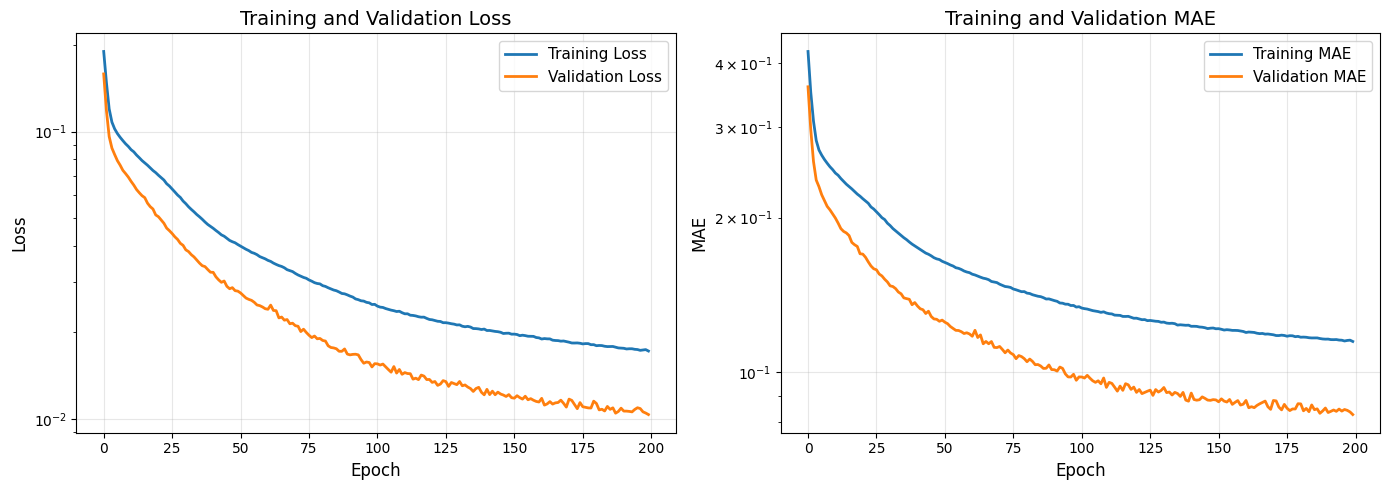

In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Training and Validation MAE', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

### Prediction vs Actual (Compact Grid)

/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ed/miniforge3/envs/g2_ml/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


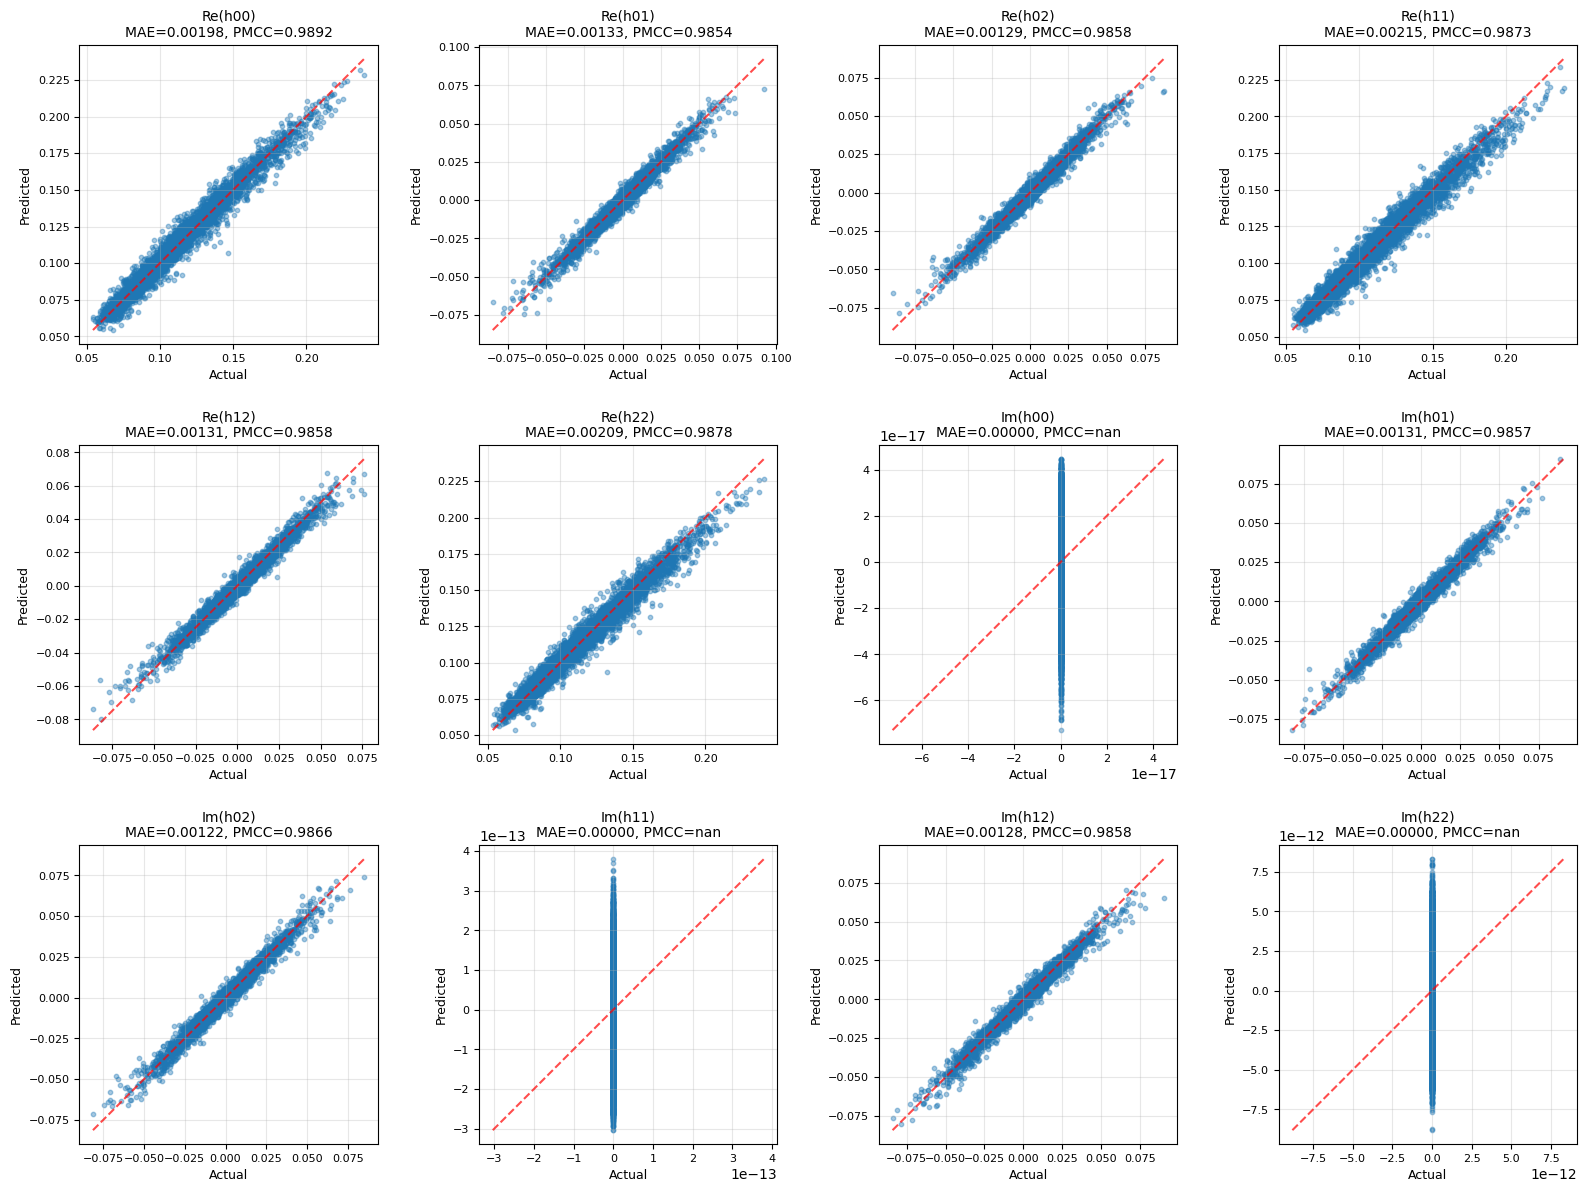

In [16]:
# Create compact grid of scatter plots for all 12 components
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

component_names = ['Re(h00)', 'Re(h01)', 'Re(h02)', 'Re(h11)', 'Re(h12)', 'Re(h22)',
                   'Im(h00)', 'Im(h01)', 'Im(h02)', 'Im(h11)', 'Im(h12)', 'Im(h22)']

for i in range(12):
    # Calculate PMCC
    pmcc = np.corrcoef(y_test_denorm[:, i], y_pred[:, i])[0, 1]
    mae = np.mean(np.abs(y_test_denorm[:, i] - y_pred[:, i]))
    
    # Scatter plot
    axes[i].scatter(y_test_denorm[:, i], y_pred[:, i], alpha=0.4, s=10)
    
    # Perfect prediction line
    min_val = min(y_test_denorm[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test_denorm[:, i].max(), y_pred[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, alpha=0.7)
    
    axes[i].set_xlabel('Actual', fontsize=9)
    axes[i].set_ylabel('Predicted', fontsize=9)
    axes[i].set_title(f'{component_names[i]}\nMAE={mae:.5f}, PMCC={pmcc:.4f}', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(labelsize=8)
    
    # Equal aspect ratio
    axes[i].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [23]:
np.mean(y_train,axis=0), np.std(y_train,axis=0)

(array([ 0.10630696, -0.00013314,  0.0004871 ,  0.10555248,  0.00031197,
         0.10615028,  0.        , -0.00168243,  0.00038101,  0.        ,
        -0.00055353,  0.        ]),
 array([0.02080146, 0.01141964, 0.01121153, 0.02081046, 0.01122076,
        0.02077936, 0.        , 0.01124828, 0.01126249, 0.        ,
        0.01129965, 0.        ]))

### Error Distribution (Compact Grid)

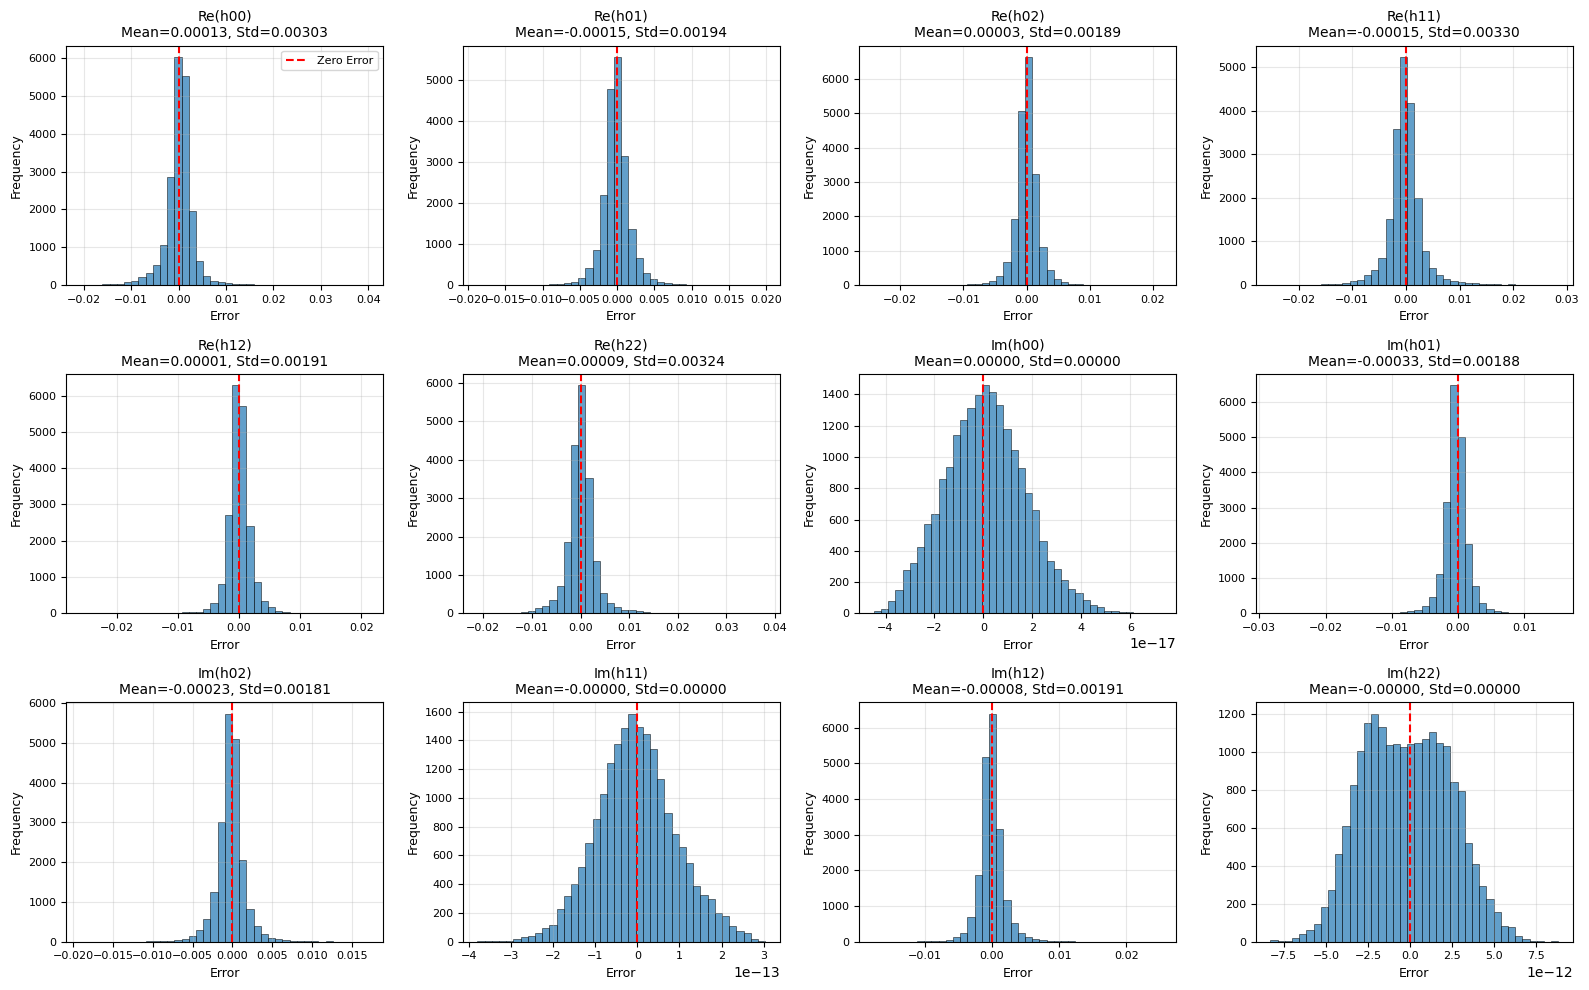

In [17]:
# Create compact grid of error histograms for all 12 components
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i in range(12):
    errors = y_test_denorm[:, i] - y_pred[:, i]
    
    axes[i].hist(errors, bins=40, alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[i].axvline(0, color='r', linestyle='--', linewidth=1.5, label='Zero Error')
    axes[i].set_xlabel('Error', fontsize=9)
    axes[i].set_ylabel('Frequency', fontsize=9)
    axes[i].set_title(f'{component_names[i]}\nMean={np.mean(errors):.5f}, Std={np.std(errors):.5f}', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(labelsize=8)
    if i == 0:
        axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

### Summary Statistics

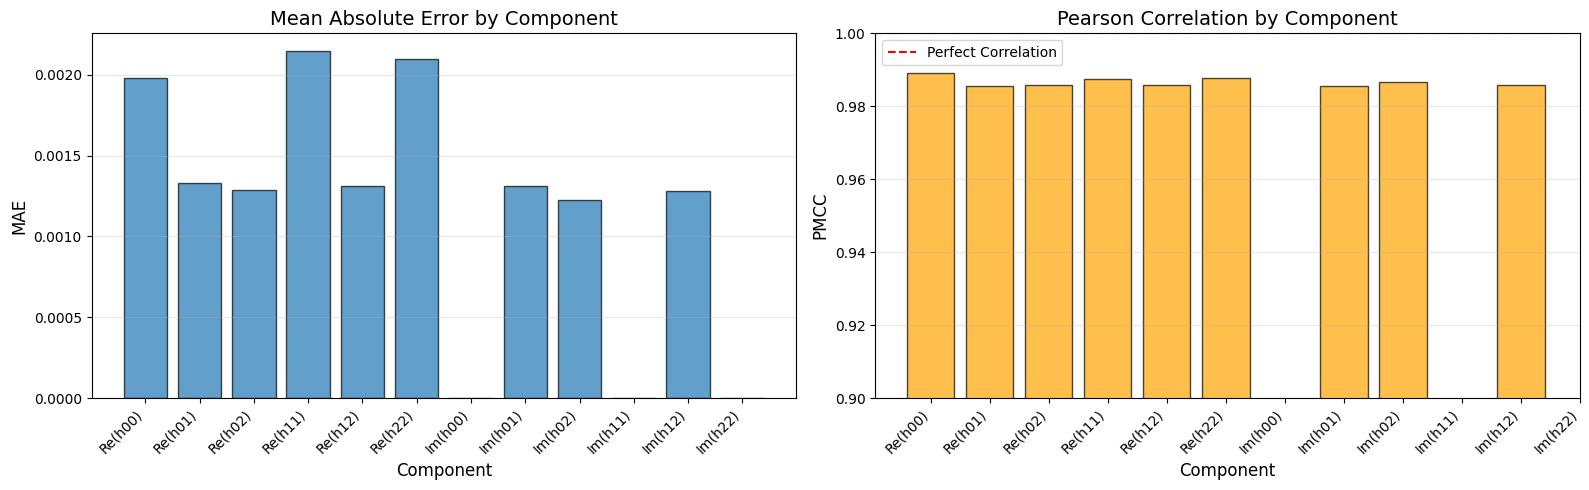


SUMMARY STATISTICS

Average MAE across components: 0.001163
Average PMCC across components: nan

Best component (by PMCC): Im(h00) (0.9892)
Worst component (by PMCC): Im(h00) (0.9854)



In [18]:
# Calculate PMCC for all components
pmccs = [np.corrcoef(y_test_denorm[:, i], y_pred[:, i])[0, 1] for i in range(12)]

# Create bar plots for MAE and PMCC
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# MAE by component
maes = [np.mean(np.abs(y_test_denorm[:, i] - y_pred[:, i])) for i in range(12)]
axes[0].bar(range(12), maes, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Component', fontsize=12)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error by Component', fontsize=14)
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(component_names, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# PMCC by component
axes[1].bar(range(12), pmccs, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Component', fontsize=12)
axes[1].set_ylabel('PMCC', fontsize=12)
axes[1].set_title('Pearson Correlation by Component', fontsize=14)
axes[1].set_xticks(range(12))
axes[1].set_xticklabels(component_names, rotation=45, ha='right')
axes[1].axhline(y=1.0, color='r', linestyle='--', linewidth=1.5, label='Perfect Correlation')
axes[1].set_ylim([min(0.9, min(pmccs) - 0.02), 1.0])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nAverage MAE across components: {np.mean(maes):.6f}")
print(f"Average PMCC across components: {np.mean(pmccs):.4f}")
print(f"\nBest component (by PMCC): {component_names[np.argmax(pmccs)]} ({max(pmccs):.4f})")
print(f"Worst component (by PMCC): {component_names[np.argmin(pmccs)]} ({min(pmccs):.4f})")
print("\n" + "="*70)

## 11. Summary

In [19]:
print("="*70)
print("TRAINING SUMMARY")
print("="*70)

print(f"\nData:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Input type: {INPUT_TYPE}")
print(f"  Input dimension: {input_dim}")
print(f"  Output dimension: 12 (6 complex components → 12 real values)")

print(f"\nModel:")
print(f"  Architecture: {input_dim} -> {' -> '.join(map(str, HIDDEN_LAYERS))} -> 12")
print(f"  Total parameters: {model.count_params():,}")
print(f"  Activation: {ACTIVATION}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")

print(f"\nTraining:")
print(f"  Epochs run: {len(history.history['loss'])}")
print(f"  Final training loss: {history.history['loss'][-1]:.6f}")
print(f"  Final validation loss: {history.history['val_loss'][-1]:.6f}")

print(f"\nTest Performance:")
print(f"  Overall MAE: {overall_mae:.6f}")
print(f"  Average PMCC: {np.mean(pmccs):.4f}")
print(f"  Average MAPE: {np.mean(mapes):.2f}%")

print("\n" + "="*70)

TRAINING SUMMARY

Data:
  Training samples: 300000
  Test samples: 20000
  Input type: c3
  Input dimension: 16
  Output dimension: 12 (6 complex components → 12 real values)

Model:
  Architecture: 16 -> 256 -> 256 -> 128 -> 64 -> 12
  Total parameters: 114,892
  Activation: swish
  Learning rate: 0.0002
  Weight decay: 0.001

Training:
  Epochs run: 200
  Final training loss: 0.017224
  Final validation loss: 0.010350

Test Performance:
  Overall MAE: 0.001163
  Average PMCC: nan
  Average MAPE: 11.74%

